# EDA

We've run a baseline model which gave us the below feature importance graph. let's explore some of the feature to see if we can learn from them. the are a lot of features that we cannot explore all of them for a cause like this one of just learning. in a real competition you would need to explore all of them to make sure you are not missing out something that can give you an advantage while keeping in mind that you have limited time.
<img src="feature-importance.png"/>

<span style="background-color: #FFFF00">Some usefull recommendation will be highlighted in Yellow so that we can remmember them in the data prep stage.</span>

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import json
from utils.data import join_df

# Categorical columns
The organisers of the competition provided columns that are categorical. let's make a list containing those columns and map them to str type when loading pandas dataset

In [4]:
def create_col_name(base_str, start_int, end_int):
    return [f'{base_str}{i}' for i in range(start_int, end_int+1)]

In [5]:
cat_cols = (['ProductCD'] + create_col_name('card', 1, 6) + ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + 
            create_col_name('M', 1, 9) + ['DeviceType', 'DeviceInfo'] + create_col_name('id_', 12, 38))

id_cols = ['TransactionID']

dep_var = 'isFraud'

In [6]:
type_map = {c: str for c in cat_cols + id_cols}

In [7]:
table_names = ['train_identity', 'train_transaction', 'test_identity', 'test_transaction']
tables = [pd.read_csv(f'data/{fname}.csv', dtype=type_map, low_memory=False) for fname in table_names]
df_train_id, df_train_trans, df_test_id, df_test_trans = tables

# Merge datasets

In [8]:
df_train = join_df(df_train_trans, df_train_id, id_cols)
df_test = join_df(df_test_trans, df_test_id, id_cols)

In [9]:
assert (df_train.shape[0] == df_train_trans.shape[0]) & (df_train.shape[1] == df_train_trans.shape[1]+ df_train_id.shape[1]-1)
assert (df_test.shape[0] == df_test_trans.shape[0]) & (df_test.shape[1] == df_test_trans.shape[1]+ df_test_id.shape[1]-1)

In [10]:
df_train.shape, df_test.shape

((590540, 434), (506691, 433))

In [11]:
col_name_map = {'id-{:02d}'.format(c):'id_{:02d}'.format(c) for c in range(1, 39)}

In [12]:
df_test.rename(columns=col_name_map,inplace=True)

In [13]:
col_type_map = {f'id_{c}':str for c in range(12, 39)}
df_test = df_test.astype(col_type_map)

# Check duplicates

In [14]:
df_train[id_cols].duplicated().any()

False

# Quick Analysis of missing values

Let's first find the percentage of missing values for each independent variable

In [15]:
#https://github.com/LefanCheng/ML_Project_IEEE_Fraud_Detection_Kaggle
def detectmissing(df):
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing_perc'] = df.isnull().sum().values / df.shape[0]*100  
    summary['Uniques'] = df.nunique().values
    
    return summary

In [16]:
train_missing = detectmissing(df_train)
train_missing.head()

,Name,dtypes,Missing_perc,Uniques
0,TransactionID,object,0.0,590540
1,isFraud,int64,0.0,2
2,TransactionDT,int64,0.0,573349
3,TransactionAmt,float64,0.0,20902
4,ProductCD,object,0.0,5


In [17]:
test_missing = detectmissing(df_test)
test_missing.head()

,Name,dtypes,Missing_perc,Uniques
0,TransactionID,object,0.0,506691
1,TransactionDT,int64,0.0,494686
2,TransactionAmt,float64,0.0,14119
3,ProductCD,object,0.0,5
4,card1,object,0.0,13244


In [18]:
df_missing = join_df(train_missing, test_missing, ['Name'],suffix='_test')

In [19]:
df_missing

,Name,dtypes,Missing_perc,Uniques,dtypes_test,Missing_perc_test,Uniques_test
0,TransactionID,object,0.000000,590540,object,0.000000,506691.0
1,isFraud,int64,0.000000,2,NaN,NaN,NaN
2,TransactionDT,int64,0.000000,573349,int64,0.000000,494686.0
3,TransactionAmt,float64,0.000000,20902,float64,0.000000,14119.0
4,ProductCD,object,0.000000,5,object,0.000000,5.0
...,...,...,...,...,...,...,...
429,id_36,object,76.126088,2,object,0.000000,3.0
430,id_37,object,76.126088,2,object,0.000000,3.0
431,id_38,object,76.126088,2,object,0.000000,3.0
432,DeviceType,object,76.155722,2,object,72.975443,2.0


We can see that some of the variables have more than 70% of missing values. we can also notice that in some cases there a big imbalance between missing values in the training set vs the test set

# Check if is there variables with just one unique value
Such variables will be useless and we can just remove them.

In [20]:
len(df_missing[(df_missing['Uniques']==1) ])

0

# Analysis of missing values in the training set vs the test set
We are interested in knowing independent variables without missing values in the training set but have missing values in the test set

In [21]:
names = df_missing[(df_missing['Missing_perc']==0)&(df_missing['Missing_perc_test']>0)]['Name'].values.tolist()

In [22]:
print(names)

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']


Looks like this is an issue with the C columns only. let's plot that to see how big is the issue

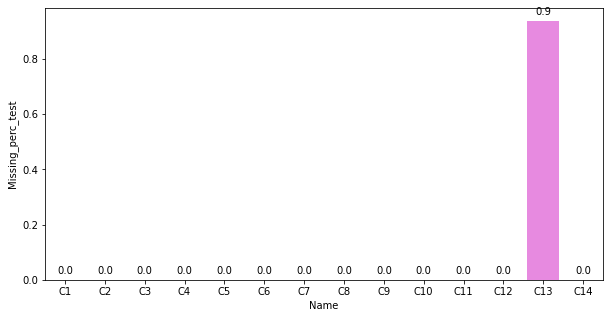

In [23]:
plt.figure(figsize=(10, 5))
data = df_missing[df_missing['Name'].isin(names)]
ax = sns.barplot(x="Name", y="Missing_perc_test",  data=data)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

<span style="background-color: #FFFF00">Looks like the variable C13 has more than 90% of missing values in the test set. this means the variable C13 might not help us to predict the test set. it is better to add about 50% of random NaN values to the training set for this variable</span>

Let's take the percentage of NaN(s) in the test set and map them to the column name. this will be use to add random NaN values to the corresponding column

In [24]:
print({ c[0]:c[1] for c in zip(data['Name'], data['Missing_perc_test'])})

{'C1': 0.000592076827889187, 'C2': 0.000592076827889187, 'C3': 0.000592076827889187, 'C4': 0.000592076827889187, 'C5': 0.000592076827889187, 'C6': 0.000592076827889187, 'C7': 0.000592076827889187, 'C8': 0.000592076827889187, 'C9': 0.000592076827889187, 'C10': 0.000592076827889187, 'C11': 0.000592076827889187, 'C12': 0.000592076827889187, 'C13': 0.9370602596059532, 'C14': 0.000592076827889187}


# Extreme Uniqueness
check if there is any variable with only one unique values in the training set

In [25]:
len(df_missing[df_missing['Uniques']==1])

0

None variable has one unique value

# Analysis of the TransactionDT
As precised by the competition page. this is not the actual time stamp but rather a timedelta from a given reference datetime

In [26]:
#reference: https://www.kaggle.com/c/ieee-fraud-detection/discussion/100071#latest-577632
train_span = (df_train['TransactionDT'].max() - df_train['TransactionDT'].min())/(3600*24)
test_span = (df_test['TransactionDT'].max() - df_test['TransactionDT'].min())/(3600*24)
total_span = (df_test['TransactionDT'].max() - df_train['TransactionDT'].min())/(3600*24)
gap_span = (df_test['TransactionDT'].min() - df_train['TransactionDT'].max())/(3600*24)
print('Time span of Train dataset is {:.2f} days'.format(train_span))
print('Time span of Test dataset is {:.2f} days'.format(test_span))
print('Time span of Total dataset is {:.2f} days'.format(total_span))
print('Time gap between train and test is {:.2f} days'.format(gap_span))

Time span of Train dataset is 182.00 days
Time span of Test dataset is 183.00 days
Time span of Total dataset is 395.00 days
Time gap between train and test is 30.00 days


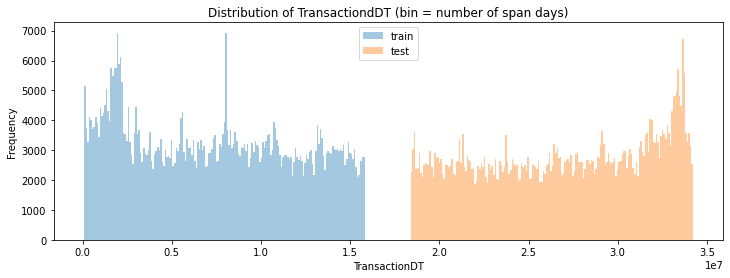

In [27]:
plt.figure(figsize=(12,4))
sns.distplot(df_train['TransactionDT'],kde=False,bins=int(train_span))
sns.distplot(df_test['TransactionDT'],kde=False,bins=int(test_span))
plt.legend(['train', 'test'])
plt.ylabel('Frequency')
plt.title('Distribution of TransactiondDT (bin = number of span days)');
plt.show()

<span style="background-color: #FFFF00">As we can see, train and test datasets are in different time periods, thus splitting data by the time order can be a good thing to do.</span>

## Feature engineering on TransactionDT
The timedelta although not real time it can still keep periodicity of days and hours. the dataset is small so there is not enough data to analyse the periodicity of months.

In [28]:
#https://github.com/LefanCheng/ML_Project_IEEE_Fraud_Detection_Kaggle
df_train['day'] = ((df_train['TransactionDT']//(3600*24)-1)%7)+1
df_test['day'] = ((df_test['TransactionDT']//(3600*24)-1)%7)+1

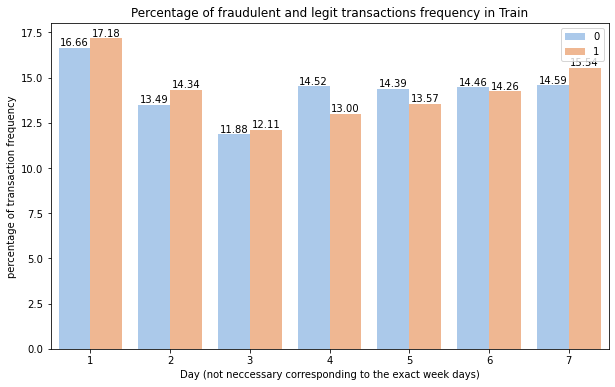

In [29]:
#https://github.com/LefanCheng/ML_Project_IEEE_Fraud_Detection_Kaggle
train_day = df_train.groupby('isFraud')['day'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('day')
plt.figure(figsize=(10,6))
barplot = sns.barplot(x="day", y="percentage", hue="isFraud", data=train_day, palette = 'pastel')
plt.legend()
plt.ylabel('percentage of transaction frequency')
plt.xlabel('Day (not neccessary corresponding to the exact week days)')
plt.title('Percentage of fraudulent and legit transactions frequency in Train')
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.show()

In [30]:
df_train['hour'] = ((df_train['TransactionDT']//3600)%24)+1
df_test['hour'] = ((df_test['TransactionDT']//3600)%24)+1

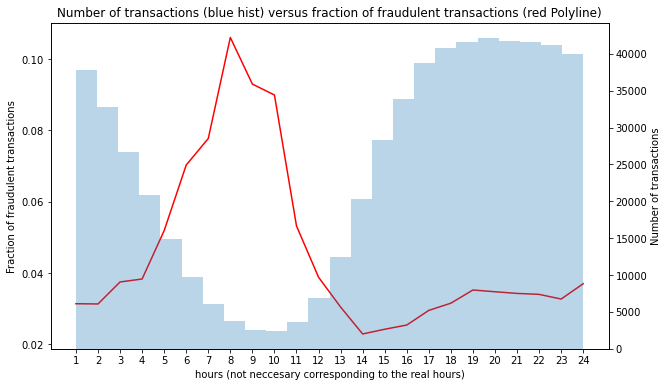

In [31]:
# https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
plt.figure(figsize=(10,6))
plt.plot(df_train.groupby('hour').mean()['isFraud'], color='r')
ax = plt.gca()
ax2 = ax.twinx()
_ = ax2.hist(df_train['hour'], alpha=0.3, bins=24)
ax.set_xlabel('hours (not neccesary corresponding to the real hours)')
ax.set_ylabel('Fraction of fraudulent transactions')
ax2.set_ylabel('Number of transactions')
plt.title('Number of transactions (blue hist) versus fraction of fraudulent transactions (red Polyline)')
plt.xticks(np.arange(1, 25, 1))
plt.show()

it seems that from 4am to 12pm (not actual time) the fraction of fraud is significantly higher than other hours

# Let's define some functions that we will need


In [56]:
# Reference: https://github.com/KaustuvDash/IEEE-Fraud-Detection
def describe(datatrain,datatest,feature):
    d = pd.DataFrame(columns=[feature,'Train','TrainFraud','TrainLegit','Test'])
    d[feature] = ['count','mean','std','min','25%','50%','75%','max','unique','NaN','NaNshare']
    for i in range(0,8):
        d['Train'].iloc[i] = datatrain[feature].describe().iloc[i]
        d['TrainFraud'].iloc[i]=datatrain[datatrain['isFraud']==1][feature].describe().iloc[i]
        d['TrainLegit'].iloc[i]=datatrain[datatrain['isFraud']==0][feature].describe().iloc[i]
        d['Test'].iloc[i]=datatest[feature].describe().iloc[i]
    d['Train'].iloc[8] = len(datatrain[feature].unique())
    d['TrainFraud'].iloc[8]=len(datatrain[datatrain['isFraud']==1][feature].unique())
    d['TrainLegit'].iloc[8]=len(datatrain[datatrain['isFraud']==0][feature].unique())
    d['Test'].iloc[8]=len(datatest[feature].unique())
    d['Train'].iloc[9] = datatrain[feature].isnull().sum()
    d['TrainFraud'].iloc[9] = datatrain[datatrain['isFraud']==1][feature].isnull().sum()
    d['TrainLegit'].iloc[9] = datatrain[datatrain['isFraud']==0][feature].isnull().sum()
    d['Test'].iloc[9]=datatest[feature].isnull().sum()
    d['Train'].iloc[10] = datatrain[feature].isnull().sum()/len(datatrain)
    d['TrainFraud'].iloc[10] = datatrain[datatrain['isFraud']==1][feature].isnull().sum()/len(datatrain[datatrain['isFraud']==1])
    d['TrainLegit'].iloc[10] = datatrain[datatrain['isFraud']==0][feature].isnull().sum()/len(datatrain[datatrain['isFraud']==0])
    d['Test'].iloc[10]=datatest[feature].isnull().sum()/len(datatest)
    return d

def describeCategory(datatrain,datatest,feature):
    d = pd.DataFrame(columns=[feature,'Train','TrainFraud','TrainLegit','Test'])
    d[feature] = ['count','unique','top','freq','NaN','NaNshare']
    for i in range(0,4):
        d['Train'].iloc[i] = datatrain[feature].describe().iloc[i]
        d['TrainFraud'].iloc[i]=datatrain[datatrain['isFraud']==1][feature].describe().iloc[i]
        d['TrainLegit'].iloc[i]=datatrain[datatrain['isFraud']==0][feature].describe().iloc[i]
        d['Test'].iloc[i]=datatest[feature].describe().iloc[i]
#     d['Train'].iloc[4] = len(datatrain[feature].unique())
#     d['TrainFraud'].iloc[8]=len(datatrain[datatrain['isFraud']==1][feature].unique())
#     d['TrainLegit'].iloc[8]=len(datatrain[datatrain['isFraud']==0][feature].unique())
#     d['Test'].iloc[8]=len(datatest[feature].unique())
    d['Train'].iloc[4] = datatrain[feature].isnull().sum()
    d['TrainFraud'].iloc[4] = datatrain[datatrain['isFraud']==1][feature].isnull().sum()
    d['TrainLegit'].iloc[4] = datatrain[datatrain['isFraud']==0][feature].isnull().sum()
    d['Test'].iloc[4]=datatest[feature].isnull().sum()
    d['Train'].iloc[5] = datatrain[feature].isnull().sum()/len(datatrain)
    d['TrainFraud'].iloc[5] = datatrain[datatrain['isFraud']==1][feature].isnull().sum()/len(datatrain[datatrain['isFraud']==1])
    d['TrainLegit'].iloc[5] = datatrain[datatrain['isFraud']==0][feature].isnull().sum()/len(datatrain[datatrain['isFraud']==0])
    d['Test'].iloc[5]=datatest[feature].isnull().sum()/len(datatest)
    return d

In [38]:
def TTScaterPlot(df_train, df_test, x, y, h,log=False):
    
    max_train = df_train[y].max()
    max_test = df_test[y].max()
    max_val = np.maximum(max_train,max_test)
    
    min_train = df_train[y].min()
    min_test = df_test[y].min()
    min_val = np.minimum(min_train,min_test)
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    ax1 = sns.scatterplot(x=x,y=y,hue="isFraud", data=df_train, alpha=0.8, hue_order=[0,1])
    ax1.set_ylim(min_val, max_val+50)
    # plt.yticks(np.arange(0,7000,500))
    # g1.axhline(6000, c='r')
    if log:
        ax1.set_yscale("log")
    plt.title(f'{x} vs {y} by {h} in Train')
    plt.subplot(1,2,2)
    ax2 = sns.scatterplot(x=x,y=y, data=df_test, alpha=0.8, hue_order=[0,1])
    ax2.set_ylim(min_val, max_val+50)
    # plt.yticks(np.arange(0,10000,1000))
    if log:
        ax2.set_yscale("log")
    plt.title(f'{x} vs {y} by {h} in Test')
    plt.show()
    
def TLegitVsFraud(df_train,x,y,log=False):
    max_val = df_train[y].max()
    
    min_val = df_train[y].min()
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    ax1=sns.scatterplot(x=x,y=y,data=df_train[df_train[dep_var]==0])
    ax1.set_ylim(min_val, max_val+50)
    if log:
        ax1.set_yscale("log")
    plt.title(f'Train {y} Normal')

    plt.subplot(1,2,2)
    ax2=sns.scatterplot(x=x,y=y,data=df_train[df_train[dep_var]==1], color='orange')
    ax2.set_ylim(min_val, max_val+50)
    if log:
        ax2.set_yscale("log")
    plt.title(f'Train {y} Fraud')

    plt.show()
    
def TTDistributionPlot(df_train,df_test,col,dep_var,log=False):
    
    plt.figure(figsize=(20,6))
    plt.subplot(1,2,1)
    
    
    if log:
        ax1=sns.distplot(np.log(df_train[df_train[dep_var]==0][col]))
        ax2=sns.distplot(np.log(df_train[df_train[dep_var]==1][col]))
    else:
        ax1=sns.distplot(df_train[df_train[dep_var]==0][col])
        ax2=sns.distplot(df_train[df_train[dep_var]==1][col])
        
    
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    plt.ylabel('Probability Density')
    plt.legend(['legit','fraud'])
    plt.suptitle(f'{col} Distribution' , fontsize=12)
    plt.title('Train')
    plt.subplot(1,2,2)
    if log:
        ax3=sns.distplot(np.log(df_test[col]))
    else:
        ax3=sns.distplot(df_test[col])
    
    fit1 = ax1.get_lines()[0].get_data() # Getting the data from the plotted line
    fit2 = ax2.get_lines()[0].get_data()
    fit3 = ax3.get_lines()[0].get_data()
    
    max_propability = np.max([np.max(fit1[1]),np.max(fit2[1]),np.max(fit3[1])])
    
    ax1.set_ylim(0,max_propability)
    ax2.set_ylim(0,max_propability)
    ax3.set_ylim(0,max_propability)
    
    plt.title('Test')
    plt.show()
    
def TTCountPlot(df_train,df_test,col,dep_var):
    
    plt.figure(figsize=(20,8))
#     plt.subplot(1,2,1)
    train_col = (df_train.groupby([dep_var])[col].value_counts(normalize=True).rename('percentage').mul(100).reset_index())
    sns.barplot(x=col, y="percentage", hue=dep_var, data=train_col, palette = 'pastel')
    plt.xticks(rotation=90)
    plt.suptitle(f'Percentage of fraud and legit by {col}', fontsize=18)
#     plt.subplot(1,2,2)
    plt.figure(figsize=(20,8))
    sns.countplot(x=col, data=df_test, palette = 'pastel')
    plt.xticks(rotation=90)
    plt.suptitle(f'Count of {col} in the test set', fontsize=18)
    plt.show()

# Analysis of C14

In [39]:
describe(df_train, df_test, 'C14')

,C14,Train,TrainFraud,TrainLegit,Test
0,count,590540.0,20663.0,569877.0,506688.0
1,mean,8.295215,10.356047,8.220491,6.08389
2,std,49.544262,82.902579,47.898725,28.315616
3,min,0.0,0.0,0.0,0.0
4,25%,1.0,0.0,1.0,1.0
5,50%,1.0,1.0,1.0,1.0
6,75%,2.0,2.0,2.0,2.0
7,max,1429.0,1426.0,1429.0,797.0
8,unique,1108,244,1085,570
9,NaN,0,0,0,3


In [40]:
df_train.loc[df_train['C14'].isnull(),'C14'] = -999
df_test.loc[df_test['C14'].isnull(),'C14'] = -999

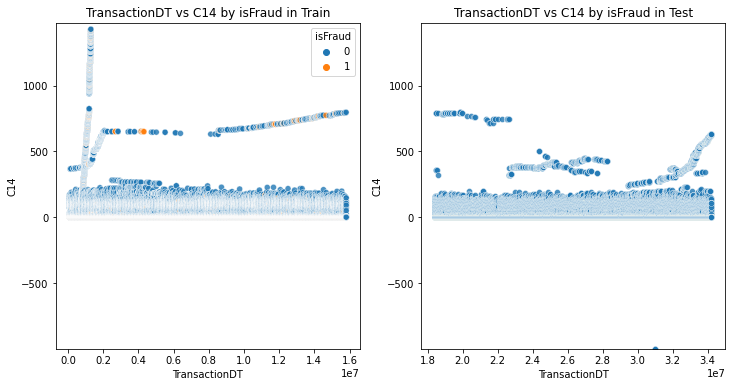

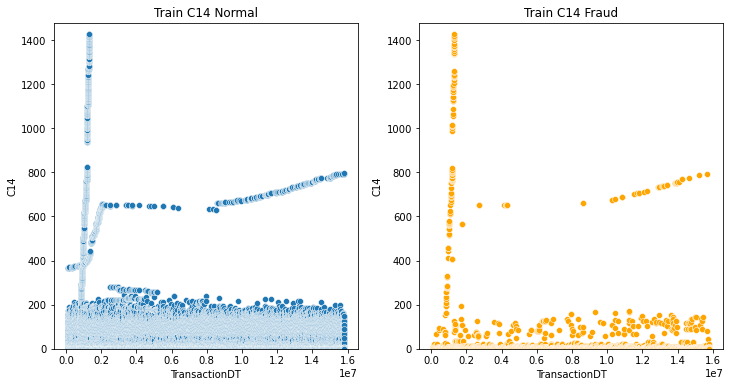

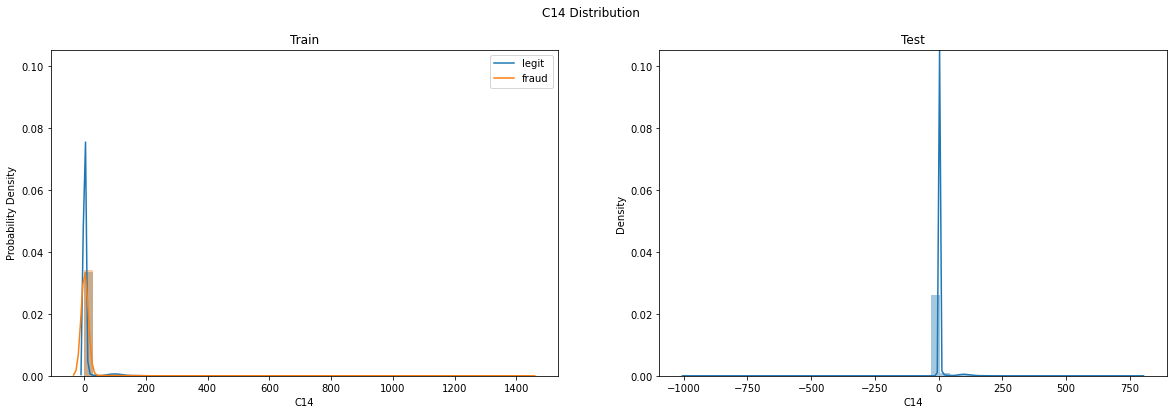

In [41]:
TTScaterPlot(df_train, df_test, 'TransactionDT', 'C14', 'isFraud')
TLegitVsFraud(df_train,'TransactionDT','C14')
TTDistributionPlot(df_train,df_test,'C14',dep_var)

# Analysis of C1

In [42]:
describe(df_train, df_test, 'C1')

,C1,Train,TrainFraud,TrainLegit,Test
0,count,590540.0,20663.0,569877.0,506688.0
1,mean,14.092458,35.53574,13.314952,10.093211
2,std,133.569018,242.97626,127.787969,79.334782
3,min,0.0,0.0,0.0,0.0
4,25%,1.0,1.0,1.0,1.0
5,50%,1.0,2.0,1.0,1.0
6,75%,3.0,6.0,3.0,3.0
7,max,4685.0,4682.0,4685.0,2950.0
8,unique,1657,497,1526,1175
9,NaN,0,0,0,3


In [43]:
df_train.loc[df_train['C1'].isnull(),'C1'] = -999
df_test.loc[df_test['C1'].isnull(),'C1'] = -999

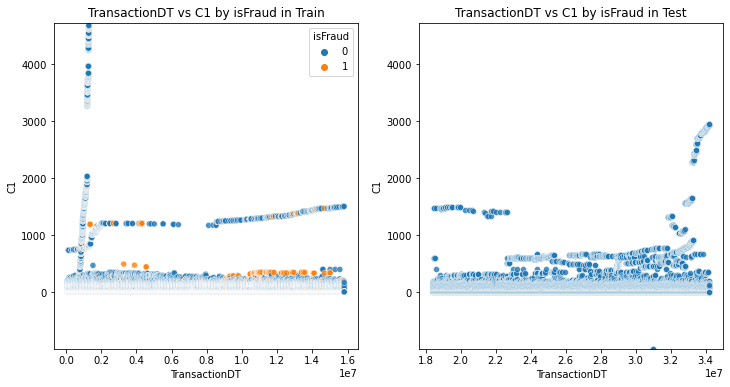

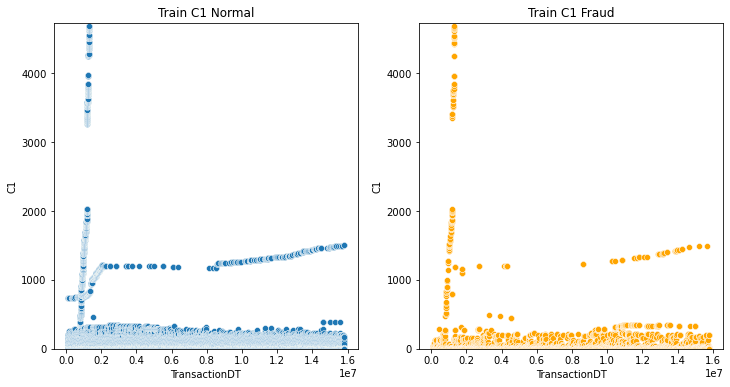

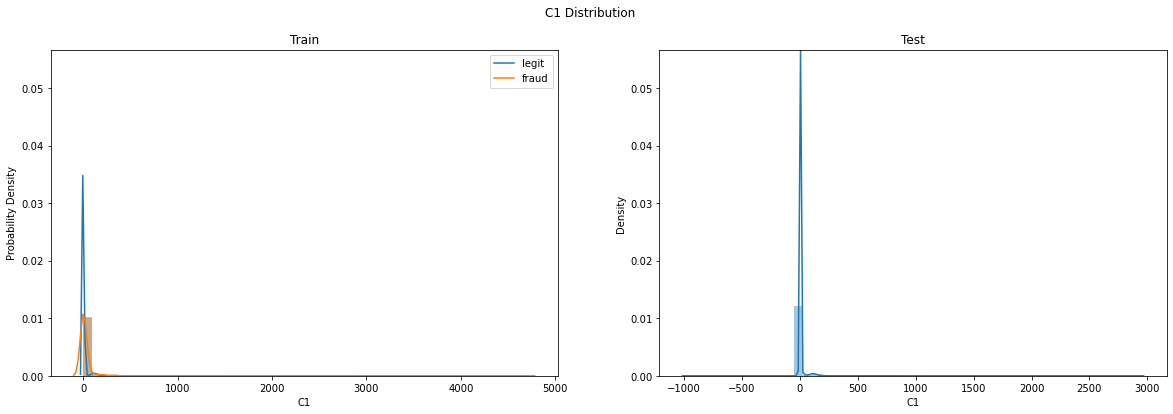

In [44]:
TTScaterPlot(df_train, df_test, 'TransactionDT', 'C1', 'isFraud')
TLegitVsFraud(df_train,'TransactionDT','C1')
TTDistributionPlot(df_train,df_test,'C1',dep_var)

# Analysis of V258

In [45]:
describe(df_train, df_test, 'V258')

,V258,Train,TrainFraud,TrainLegit,Test
0,count,130430.0,10192.0,120238.0,126728.0
1,mean,1.34351,3.400903,1.169115,1.667824
2,std,2.015811,4.493237,1.519058,7.692319
3,min,0.0,0.0,0.0,0.0
4,25%,1.0,1.0,1.0,1.0
5,50%,1.0,2.0,1.0,1.0
6,75%,1.0,4.0,1.0,1.0
7,max,66.0,48.0,66.0,269.0
8,unique,68,50,47,271
9,NaN,460110,10471,449639,379963


In [46]:
df_train.loc[df_train['V258'].isnull(),'V258'] = -999
df_test.loc[df_test['V258'].isnull(),'V258'] = -999

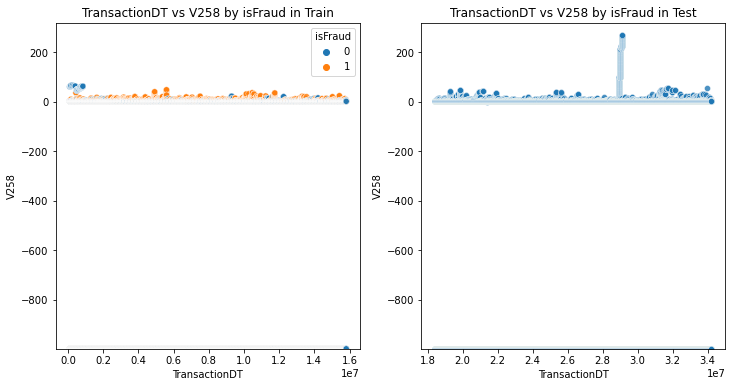

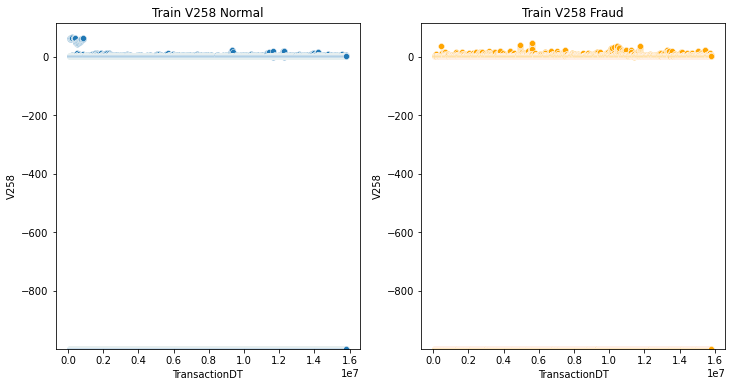

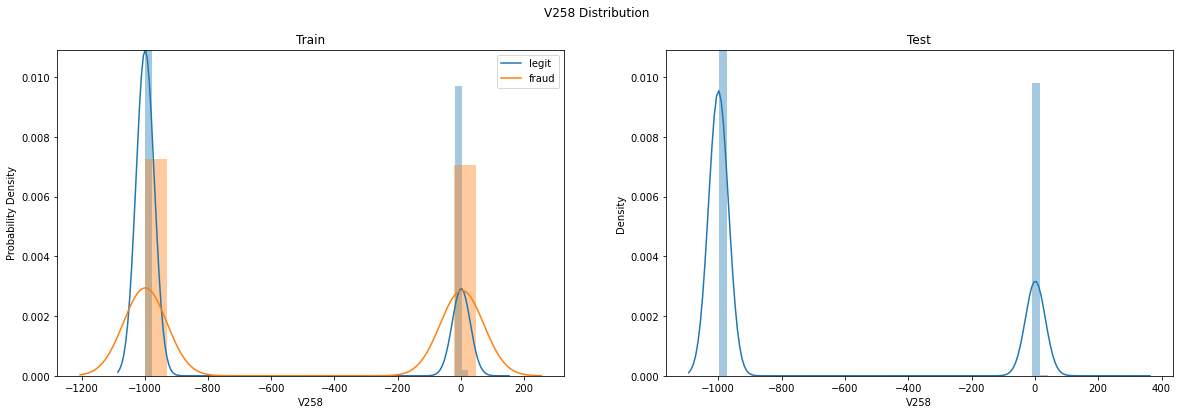

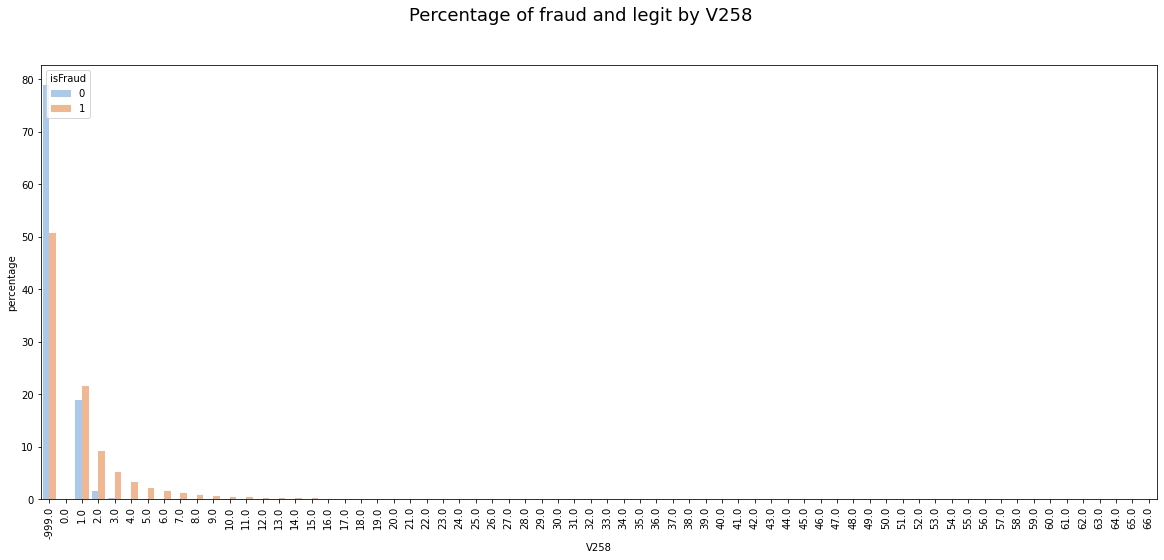

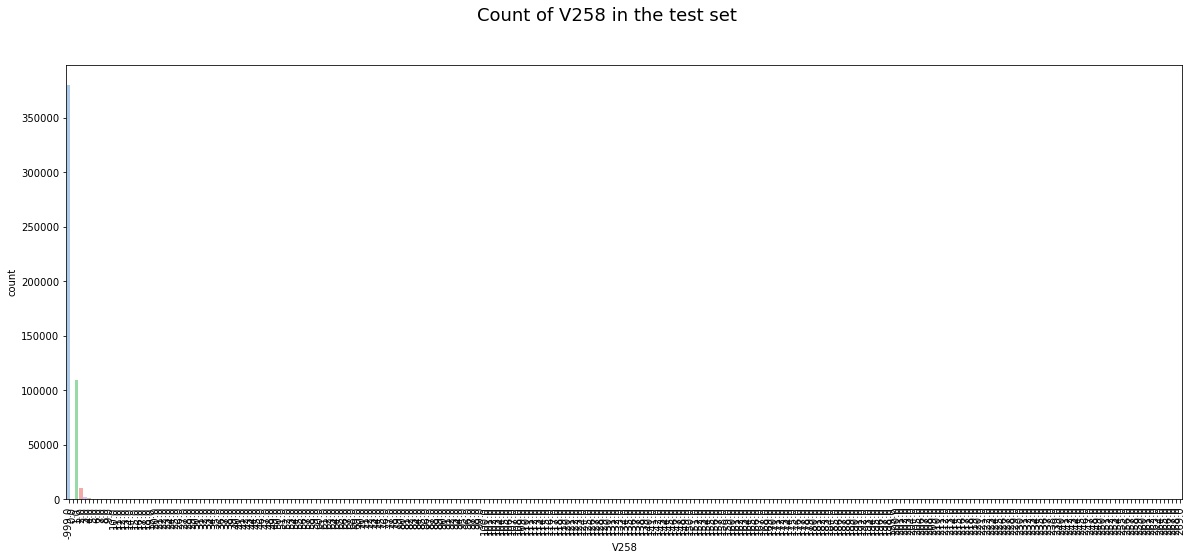

In [49]:
TTScaterPlot(df_train, df_test, 'TransactionDT', 'V258', 'isFraud')
TLegitVsFraud(df_train,'TransactionDT','V258')
TTDistributionPlot(df_train,df_test,'V258',dep_var)
TTCountPlot(df_train,df_test,'V258',dep_var)

# Analysis of V91

In [50]:
describe(df_train, df_test, 'V91')

,V91,Train,TrainFraud,TrainLegit,Test
0,count,501376.0,16387.0,484989.0,494610.0
1,mean,0.420461,0.098127,0.431352,0.35681
2,std,0.561865,0.349208,0.564455,0.534183
3,min,0.0,0.0,0.0,0.0
4,25%,0.0,0.0,0.0,0.0
5,50%,0.0,0.0,0.0,0.0
6,75%,1.0,0.0,1.0,1.0
7,max,6.0,6.0,6.0,8.0
8,unique,8,8,8,10
9,NaN,89164,4276,84888,12081


In [51]:
df_train.loc[df_train['V91'].isnull(),'V91'] = -10
df_test.loc[df_test['V91'].isnull(),'V91'] = -10

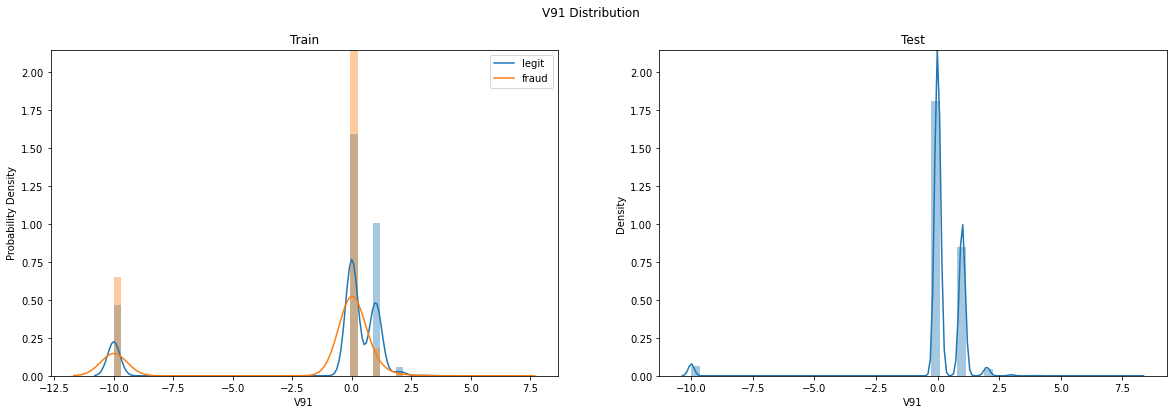

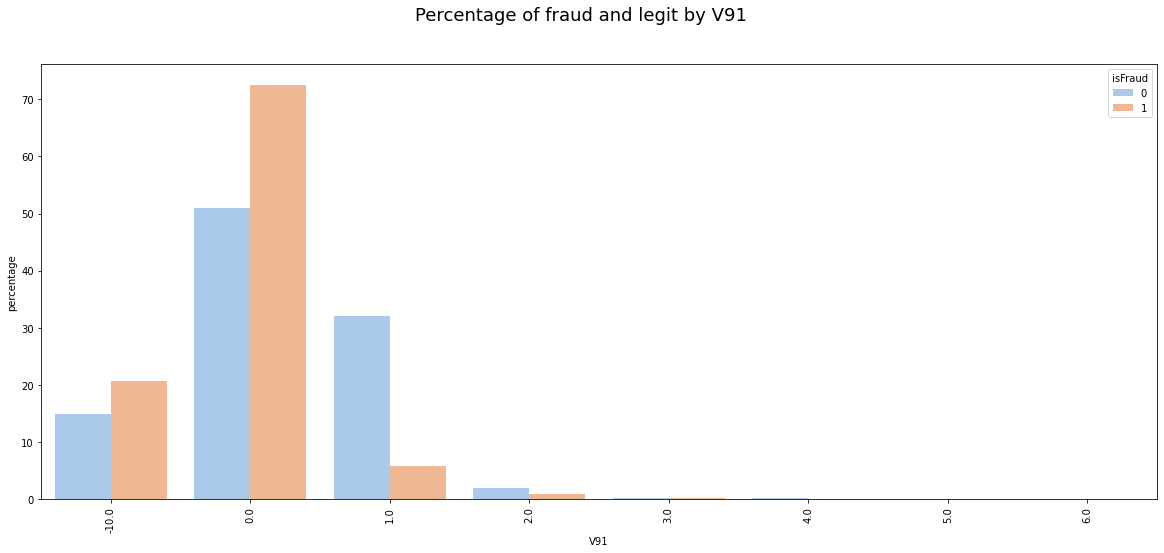

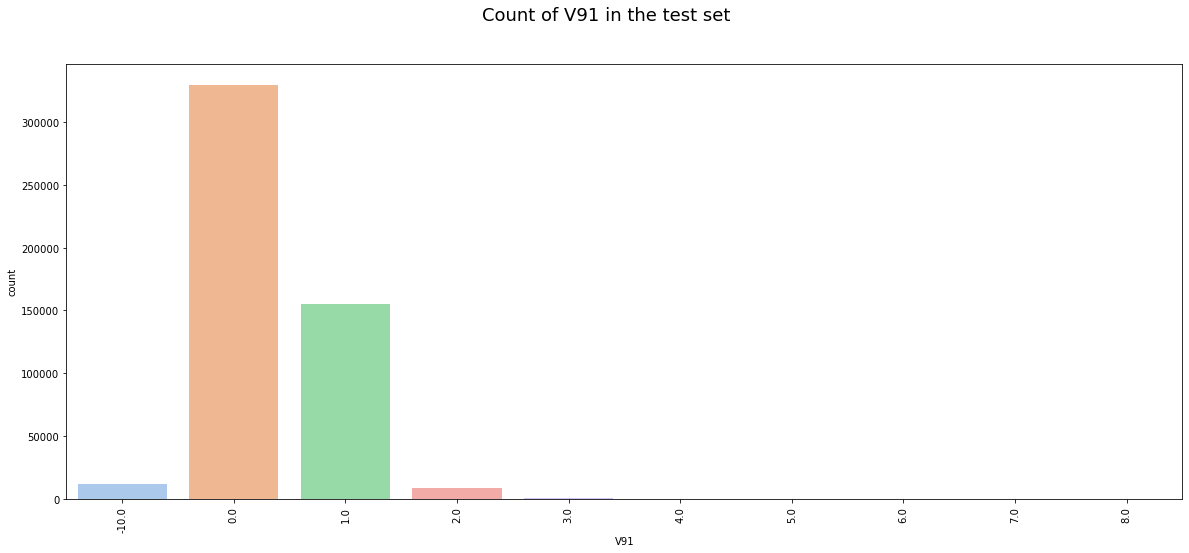

In [52]:
TTDistributionPlot(df_train,df_test,'V91',dep_var)
TTCountPlot(df_train,df_test,'V91',dep_var)

# Analysis of TransactionAmt

In [53]:
describe(df_train, df_test, 'TransactionAmt')

,TransactionAmt,Train,TrainFraud,TrainLegit,Test
0,count,590540.0,20663.0,569877.0,506691.0
1,mean,135.027176,149.244779,134.511665,134.725568
2,std,239.162522,232.212163,239.395078,245.779822
3,min,0.251,0.292,0.251,0.018
4,25%,43.321,35.044,43.97,40.0
5,50%,68.769,75.0,68.5,67.95
6,75%,125.0,161.0,120.0,125.0
7,max,31937.391,5191.0,31937.391,10270.0
8,unique,20902,2515,20560,14119
9,NaN,0,0,0,0


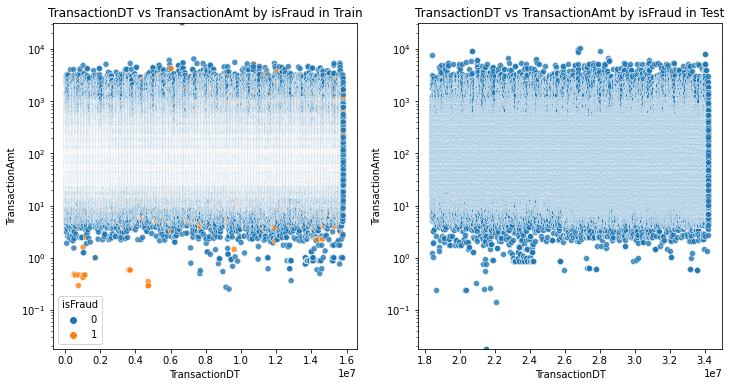

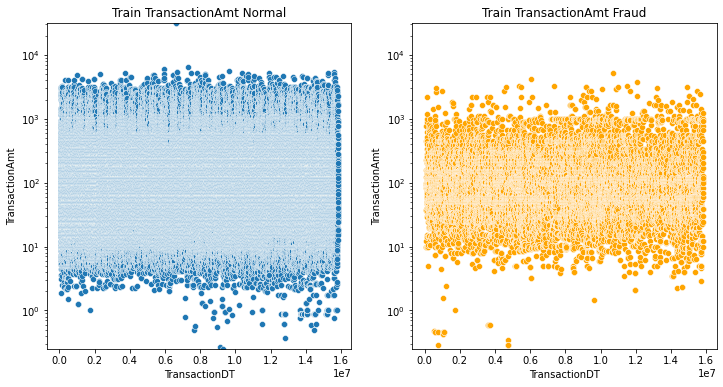

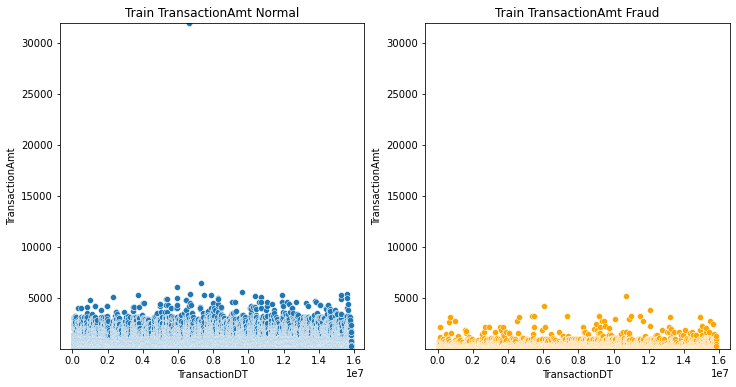

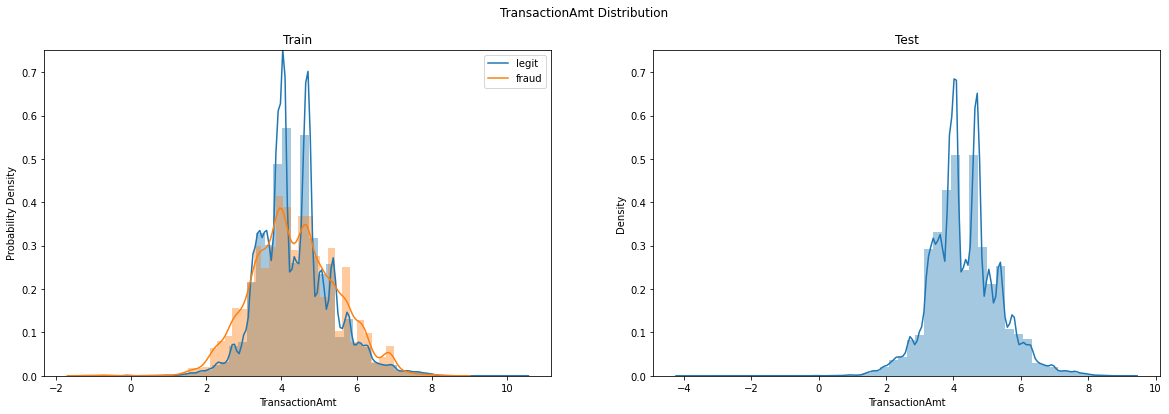

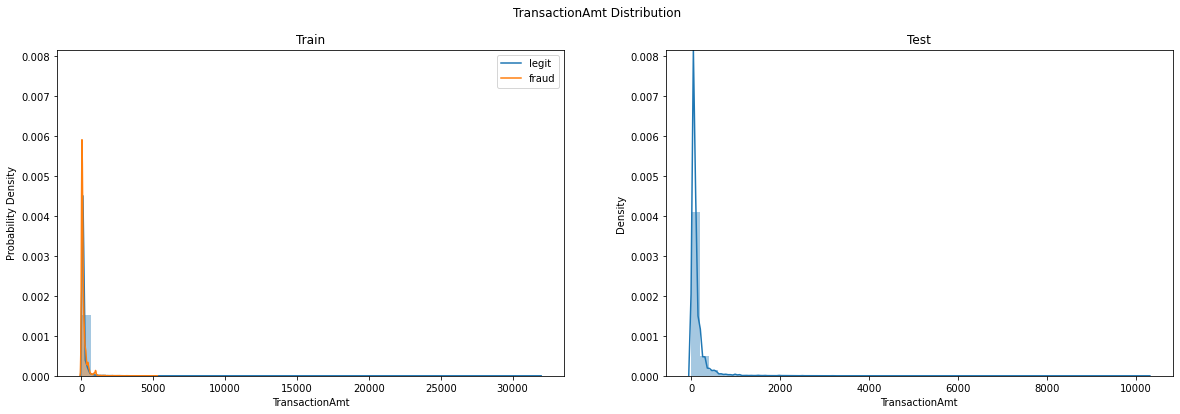

In [55]:
TTScaterPlot(df_train, df_test, 'TransactionDT', 'TransactionAmt', 'isFraud',log=True)
TLegitVsFraud(df_train,'TransactionDT','TransactionAmt',log=True)
TLegitVsFraud(df_train,'TransactionDT','TransactionAmt',log=False)
TTDistributionPlot(df_train,df_test,'TransactionAmt',dep_var,log=True)
TTDistributionPlot(df_train,df_test,'TransactionAmt',dep_var,log=False)

Looks like the fraudsters avoid transactions with extreme amount. they don't go for too small or too big.

<span style="background-color: #FFFF00">Looks like we have higher V257 in the test set, what should we do about it?</span>

# Analysis of R_emaildomain

In [61]:
describeCategory(df_train, df_test, 'R_emaildomain')

,R_emaildomain,Train,TrainFraud,TrainLegit,Test
0,count,137291,11227,126064,135870
1,unique,60,32,60,60
2,top,gmail.com,gmail.com,gmail.com,gmail.com
3,freq,57147,6811,50336,61738
4,NaN,453249,9436,443813,370821
5,NaNshare,0.767516,0.456662,0.778787,0.731848


In [62]:
df_train.loc[df_train['R_emaildomain'].isnull(),'R_emaildomain'] = '<UNK>'
df_test.loc[df_test['R_emaildomain'].isnull(),'R_emaildomain'] = '<UNK>'

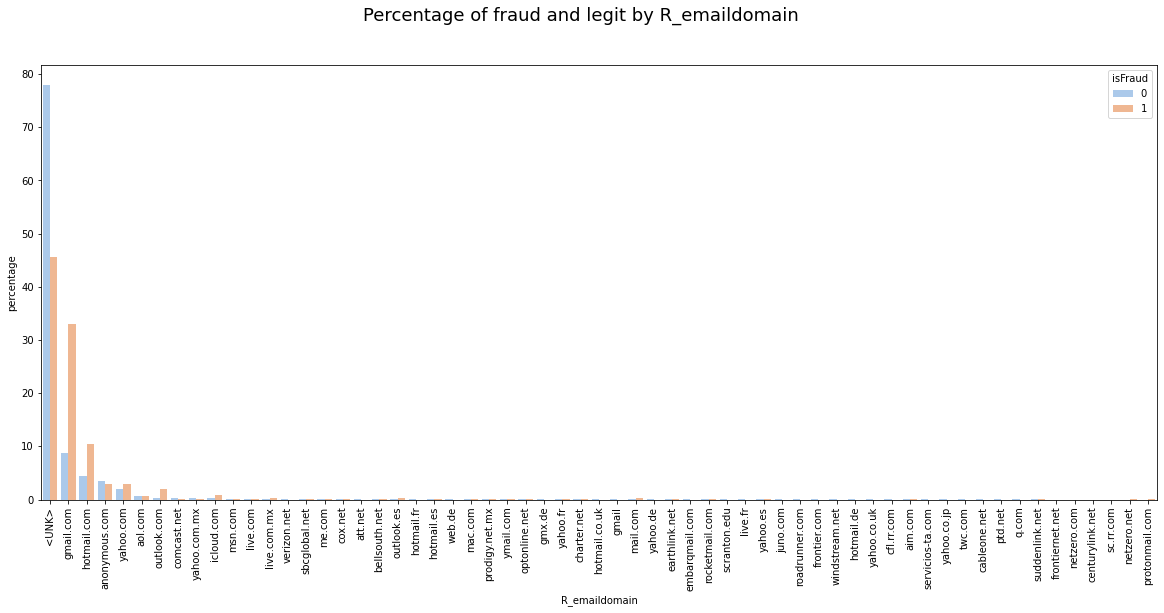

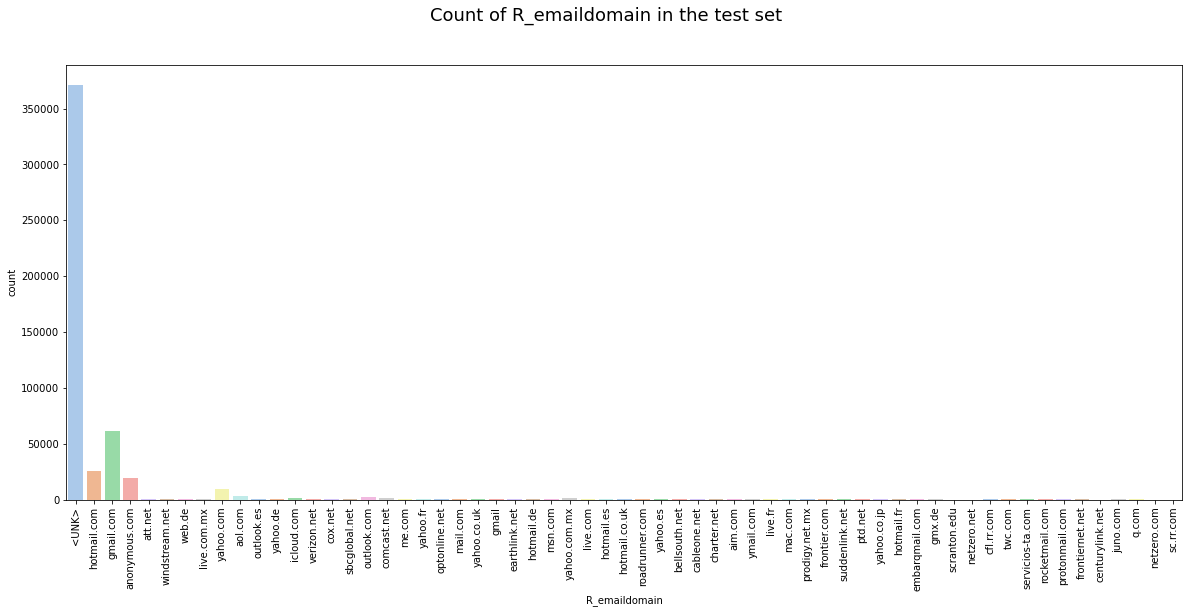

In [63]:
TTCountPlot(df_train,df_test,'R_emaildomain',dep_var)

We can see that some domain names have typos. fixing them could help but I have no time to do that. but it is a good thing to give a try.

# Analysis of M3

In [65]:
describeCategory(df_train, df_test, 'M3')

,M3,Train,TrainFraud,TrainLegit,Test
0,count,319440,6342,313098,330052
1,unique,2,2,2,2
2,top,T,T,T,T
3,freq,251731,4293,247438,266513
4,NaN,271100,14321,256779,176639
5,NaNshare,0.459071,0.693075,0.450587,0.348613


In [66]:
df_train.loc[df_train['M3'].isnull(),'M3'] = '<UNK>'
df_test.loc[df_test['M3'].isnull(),'M3'] = '<UNK>'

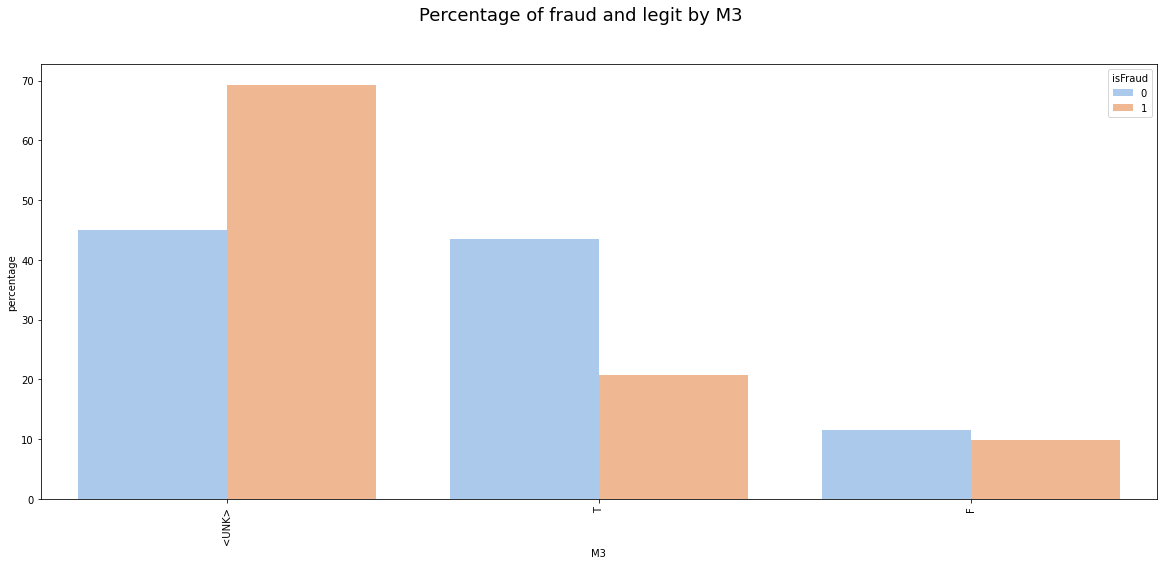

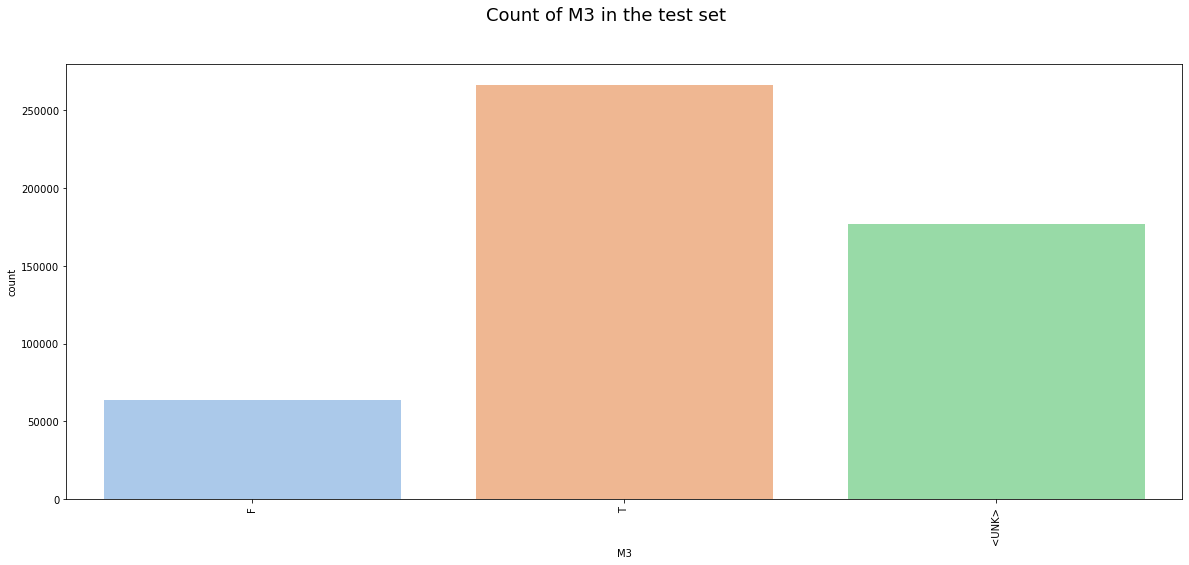

In [67]:
TTCountPlot(df_train,df_test,'M3',dep_var)

# Analysis of D2

In [68]:
describe(df_train, df_test, 'D2')

,D2,Train,TrainFraud,TrainLegit,Test
0,count,309743.0,7870.0,301873.0,271922.0
1,mean,169.563231,77.774206,171.956223,188.666621
2,std,177.315865,128.697847,177.773639,197.099611
3,min,0.0,0.0,0.0,0.0
4,25%,26.0,2.0,27.0,26.0
5,50%,97.0,16.0,100.0,112.0
6,75%,276.0,95.0,280.0,305.0
7,max,640.0,637.0,640.0,641.0
8,unique,642,542,642,643
9,NaN,280797,12793,268004,234769


In [26]:
df_train.loc[df_train['D2'].isnull(),'D2'] = -999
df_test.loc[df_test['D2'].isnull(),'D2'] = -999

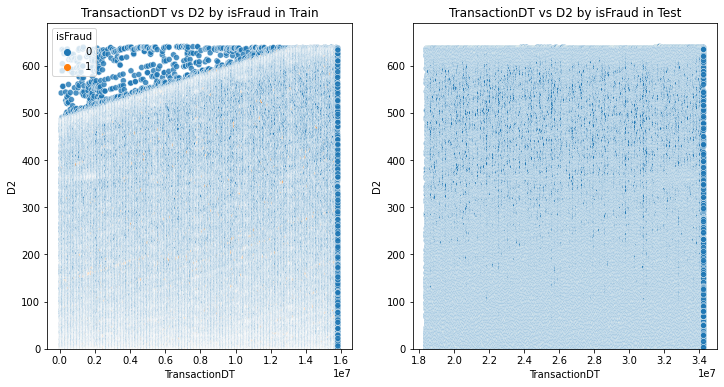

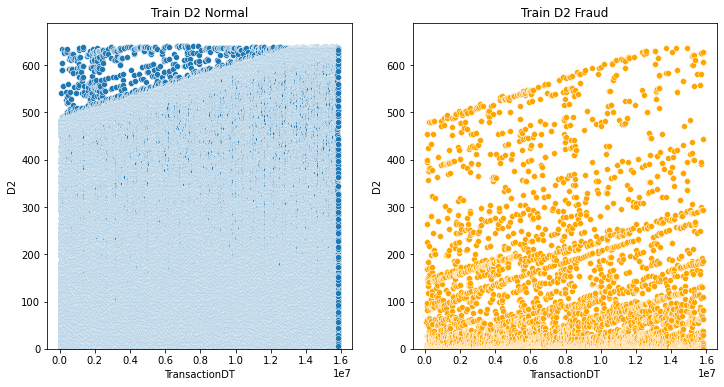

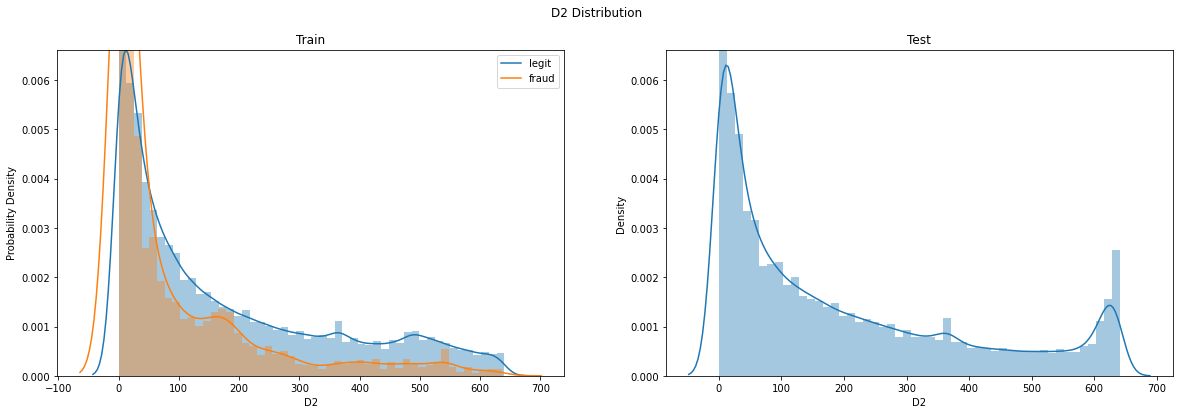

In [72]:
TTScaterPlot(df_train, df_test, 'TransactionDT', 'D2', 'isFraud',log=False)
TLegitVsFraud(df_train,'TransactionDT','D2',log=False)
TTDistributionPlot(df_train,df_test,'D2',dep_var,log=False)

# Analysis of card6

In [73]:
describeCategory(df_train, df_test, 'card6')

,card6,Train,TrainFraud,TrainLegit,Test
0,count,588969,20624,568345,503684
1,unique,4,2,4,3
2,top,debit,debit,debit,debit
3,freq,439938,10674,429264,385021
4,NaN,1571,39,1532,3007
5,NaNshare,0.00266,0.001887,0.002688,0.005935


In [74]:
df_train['card6'].unique()

array(['credit', 'debit', nan, 'debit or credit', 'charge card'],
      dtype=object)

In [75]:
df_train.loc[df_train['card6'].isnull(),'card6'] = '<UNK>'
df_test.loc[df_test['card6'].isnull(),'card6'] = '<UNK>'

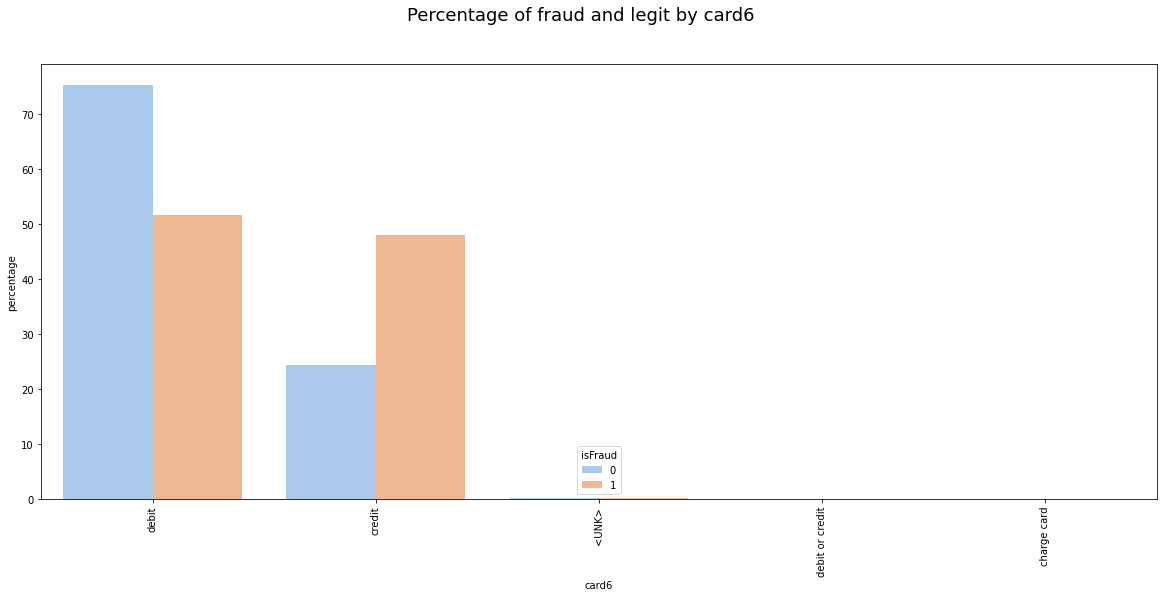

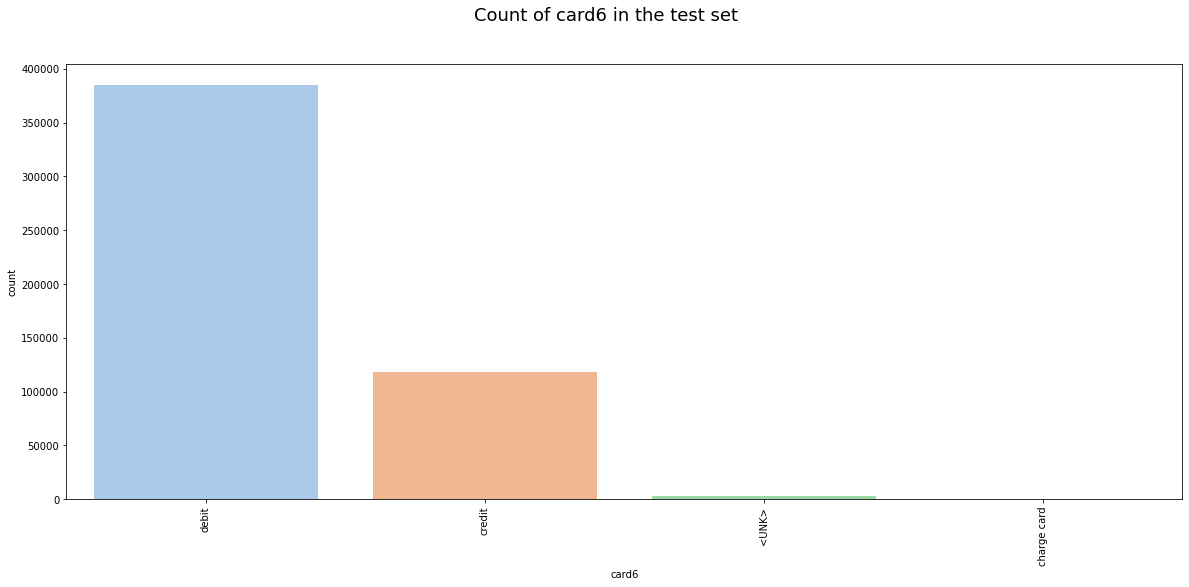

In [76]:
TTCountPlot(df_train,df_test,'card6',dep_var)

# Analysis of card5

In [77]:
describeCategory(df_train, df_test, 'card5')

,card5,Train,TrainFraud,TrainLegit,Test
0,count,586281,20453,565828,502144
1,unique,119,49,118,102
2,top,226.0,226.0,226.0,226.0
3,freq,296546,8753,287793,256991
4,NaN,4259,210,4049,4547
5,NaNshare,0.007212,0.010163,0.007105,0.008974


In [78]:
df_train.loc[df_train['card5'].isnull(),'card5'] = '<UNK>'
df_test.loc[df_test['card5'].isnull(),'card5'] = '<UNK>'

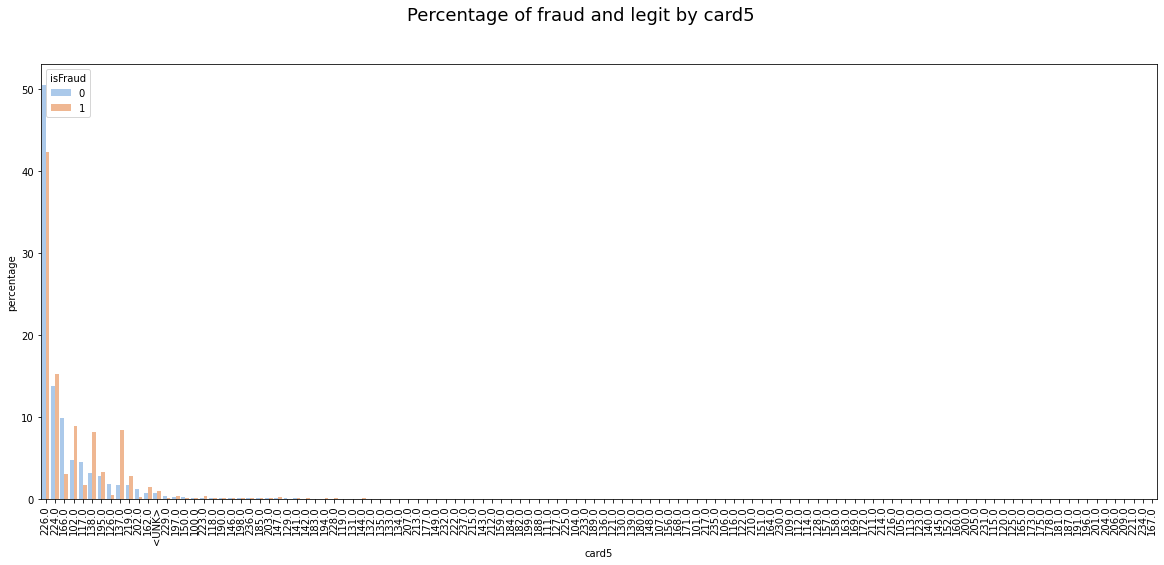

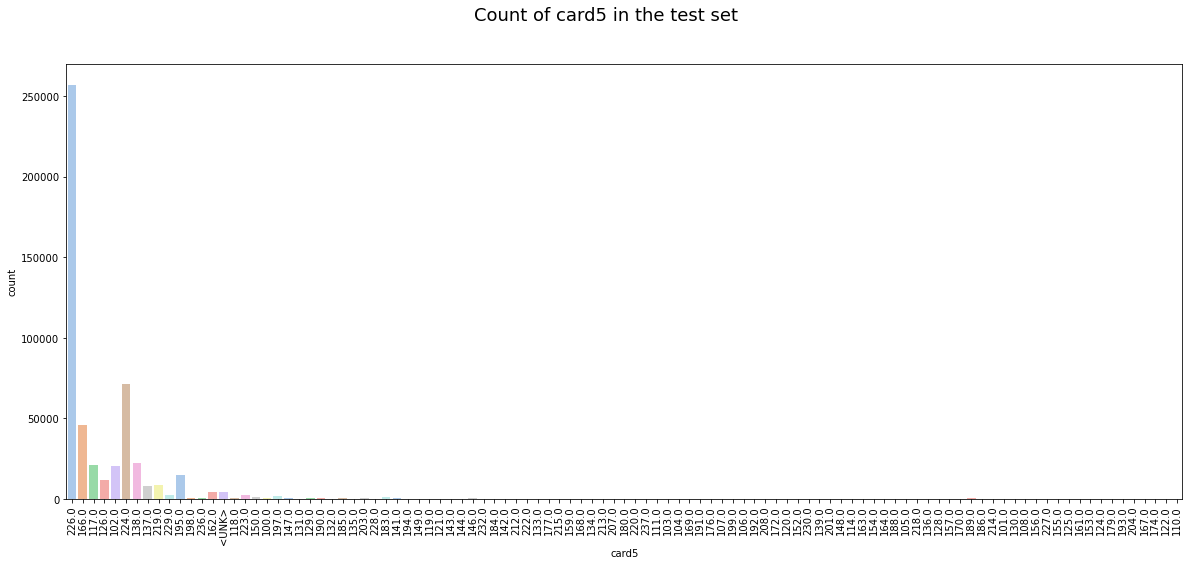

In [79]:
TTCountPlot(df_train,df_test,'card5',dep_var)

# Look at other columns that might be of interest

#### ProductCD

In [61]:
describeCategory(df_train, df_test, 'ProductCD')

,ProductCD,Train,TrainFraud,TrainLegit,Test
0,count,590540,20663,569877,506691
1,unique,5,5,5,5
2,top,W,W,W,W
3,freq,439670,8969,430701,360987
4,NaN,0,0,0,0
5,NaNshare,0.0,0.0,0.0,0.0


In [62]:
df_train['ProductCD'].unique()

array(['W', 'H', 'C', 'S', 'R'], dtype=object)

In [63]:
df_test['ProductCD'].unique()

array(['W', 'C', 'S', 'H', 'R'], dtype=object)

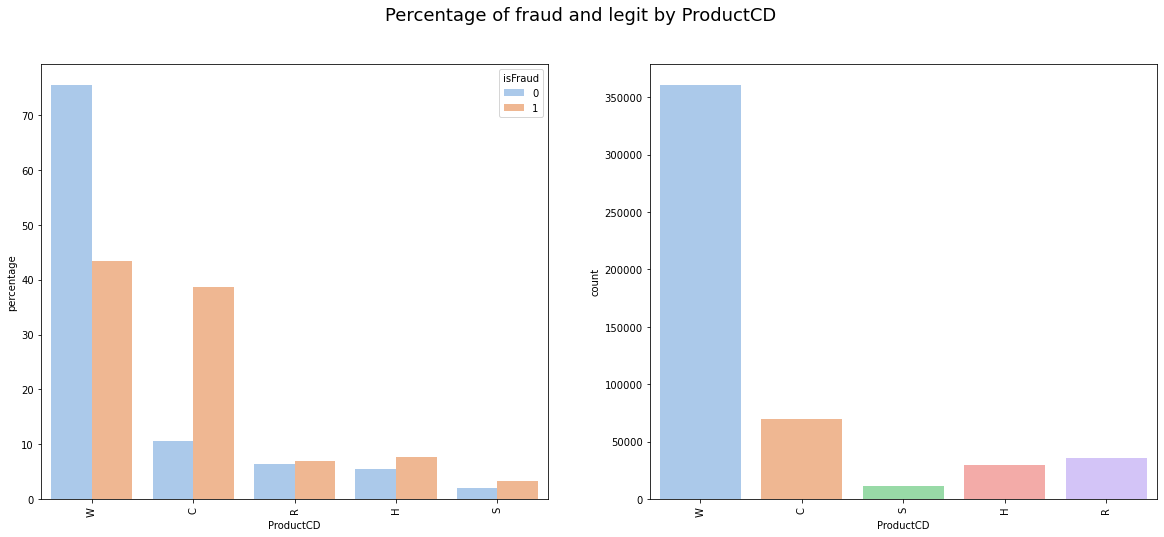

In [66]:
TTCountPlot(df_train,df_test,'ProductCD',dep_var)

# Analysis of id_31

Id_31 is a special one in a sense it has device info. so I decided to have a quick look on it.

In [57]:
describeCategory(df_train, df_test, 'id_31')

,id_31,Train,TrainFraud,TrainLegit,Test
0,count,140282,11171,129111,506691
1,unique,130,99,128,136
2,top,chrome 63.0,chrome 63.0,chrome 63.0,nan
3,freq,22000,1503,20497,370066
4,NaN,450258,9492,440766,0
5,NaNshare,0.762451,0.459372,0.773441,0.0


In [58]:
df_train['id_31'].unique()

array([nan, 'samsung browser 6.2', 'mobile safari 11.0', 'chrome 62.0',
       'chrome 62.0 for android', 'edge 15.0', 'mobile safari generic',
       'chrome 49.0', 'chrome 61.0', 'edge 16.0', 'safari generic',
       'edge 14.0', 'chrome 56.0 for android', 'firefox 57.0',
       'chrome 54.0 for android', 'mobile safari uiwebview', 'chrome',
       'chrome 62.0 for ios', 'firefox', 'chrome 60.0 for android',
       'mobile safari 10.0', 'chrome 61.0 for android',
       'ie 11.0 for desktop', 'ie 11.0 for tablet', 'mobile safari 9.0',
       'chrome generic', 'other', 'chrome 59.0 for android',
       'firefox 56.0', 'android webview 4.0', 'chrome 55.0', 'opera 49.0',
       'ie', 'chrome 55.0 for android', 'firefox 52.0',
       'chrome 57.0 for android', 'chrome 56.0',
       'chrome 46.0 for android', 'chrome 58.0', 'firefox 48.0',
       'chrome 59.0', 'samsung browser 4.0', 'edge 13.0',
       'chrome 53.0 for android', 'chrome 58.0 for android',
       'chrome 60.0', 'mobile sa

In [59]:
df_train.loc[df_train['id_31'].isnull(),'id_31'] = '<UNK>'
df_test.loc[df_test['id_31'].isnull(),'id_31'] = '<UNK>'

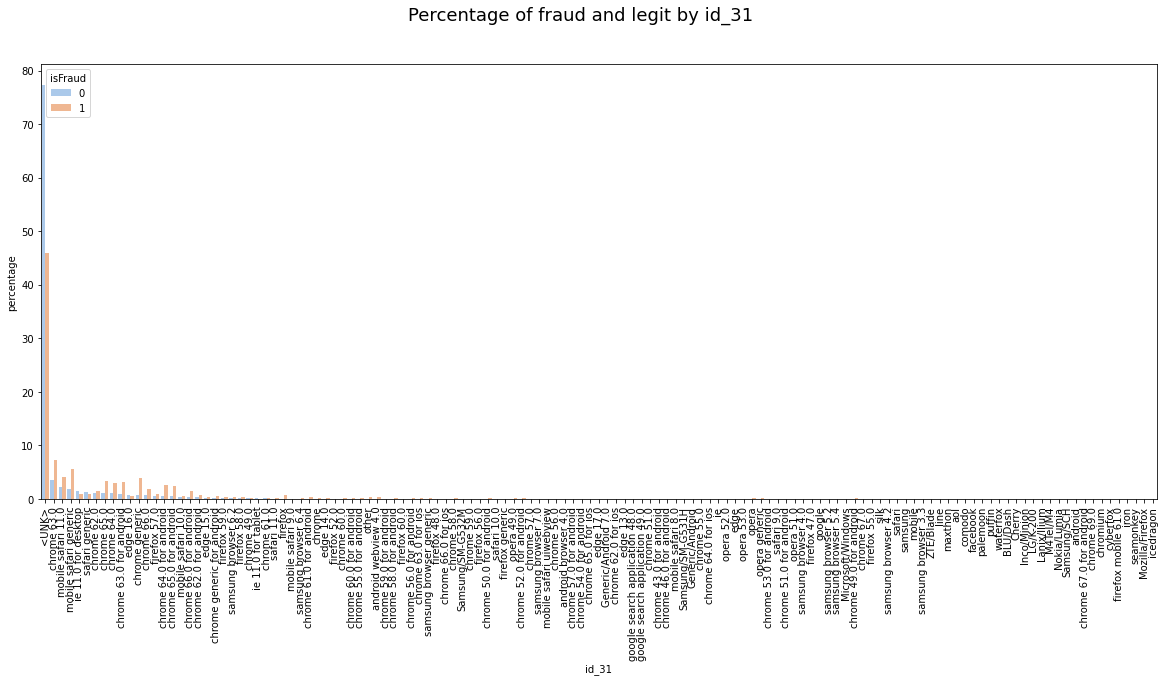

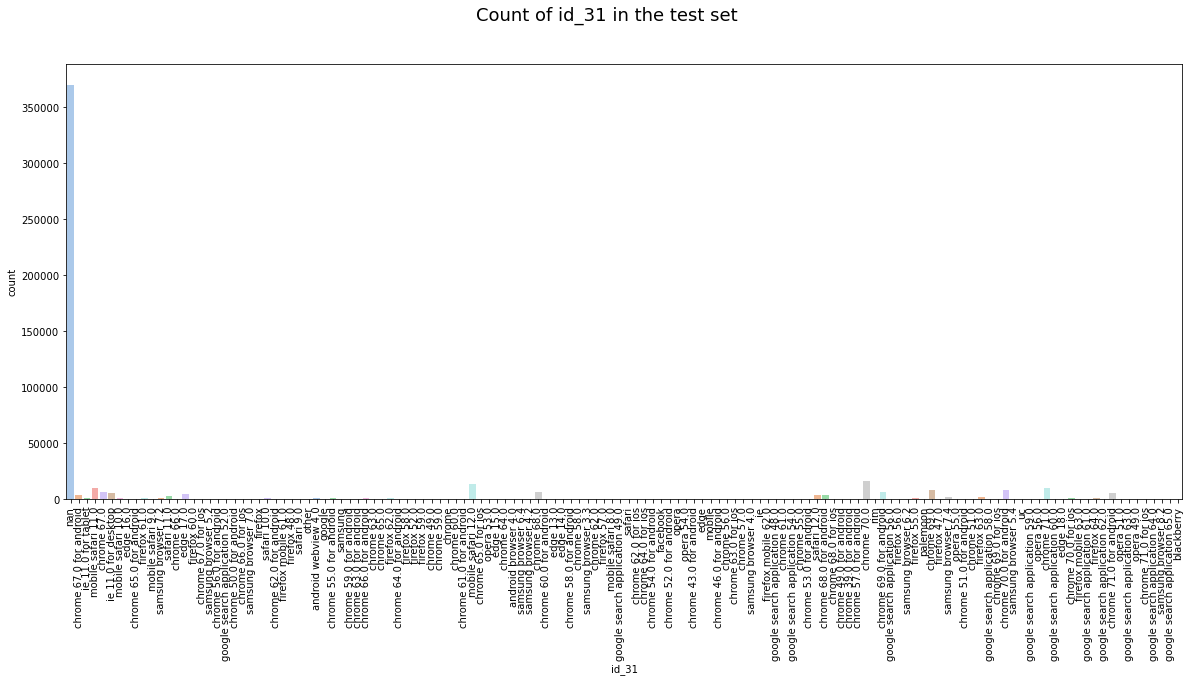

In [60]:
TTCountPlot(df_train,df_test,'id_31',dep_var)

<span style="background-color: #FFFF00">Looks like some NaN values are encoded as the string nan. we need to replace them with np.nan. also it would be worth trying to split device name and it's version</span>

#### id_23

In [80]:
describeCategory(df_train, df_test, 'id_23')

,id_23,Train,TrainFraud,TrainLegit,Test
0,count,5169,426,4743,506691
1,unique,3,3,3,4
2,top,IP_PROXY:TRANSPARENT,IP_PROXY:TRANSPARENT,IP_PROXY:TRANSPARENT,nan
3,freq,3489,245,3244,501629
4,NaN,585371,20237,565134,0
5,NaNshare,0.991247,0.979383,0.991677,0.0


In [81]:
df_train.loc[df_train['id_23'].isnull(),'id_23'] = '<UNK>'
df_test.loc[df_test['id_23'].isnull(),'id_23'] = '<UNK>'

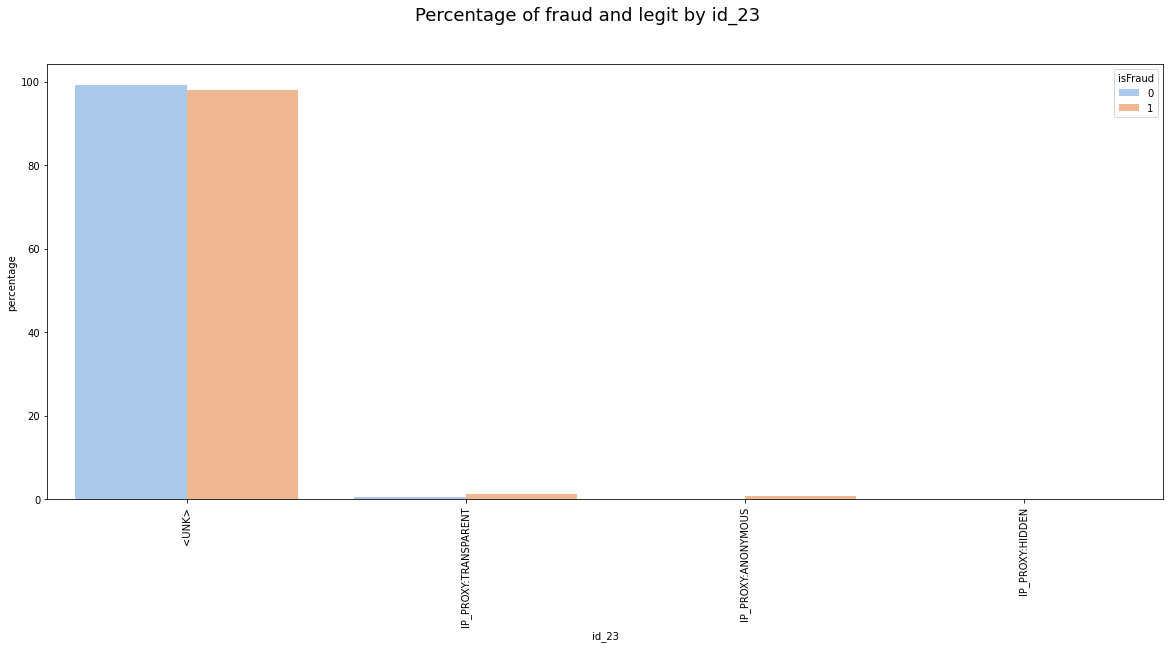

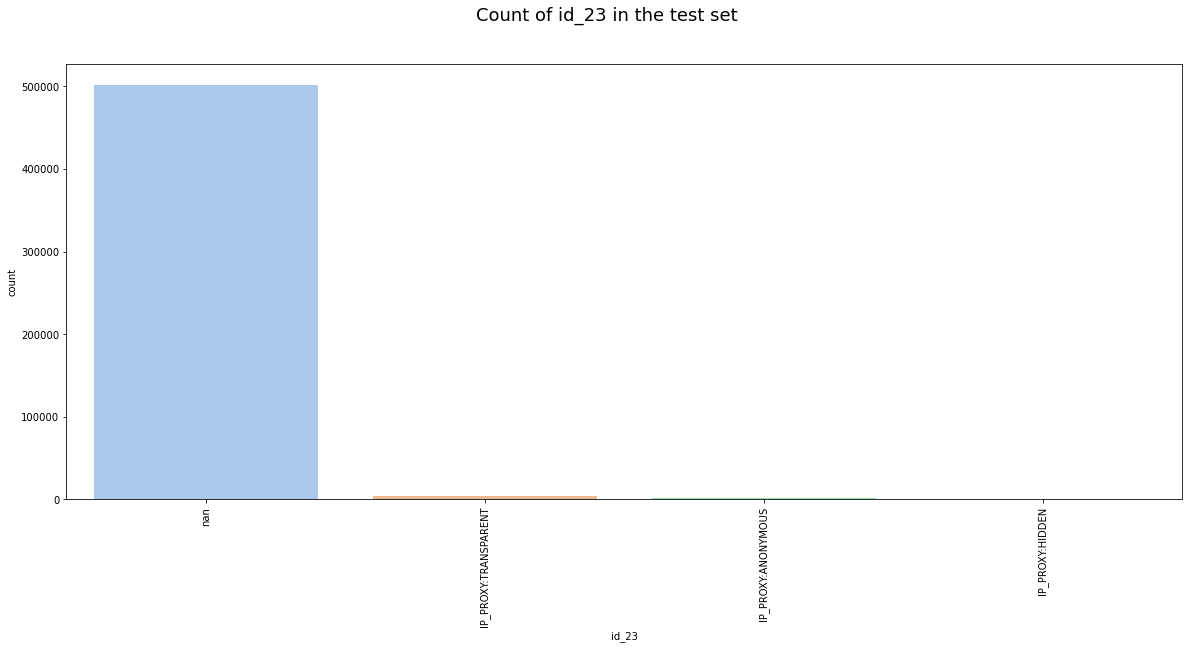

In [82]:
TTCountPlot(df_train,df_test,'id_23',dep_var)

There is a few reasons as to why this column is not predictive. 1st it is almost made of NaN values. second there is a value called nan instead of it being NaN. to make things worse, this value is only present in the test set. 
<span style="background-color: #FFFF00">I recommend that we change all nan values in the id_** fields with np.nan</span>

# Analysis of P_emaildomain

In [83]:
describeCategory(df_train, df_test, 'P_emaildomain')

,P_emaildomain,Train,TrainFraud,TrainLegit,Test
0,count,496084,17873,478211,437499
1,unique,59,42,59,60
2,top,gmail.com,gmail.com,gmail.com,gmail.com
3,freq,228355,9943,218412,207448
4,NaN,94456,2790,91666,69192
5,NaNshare,0.159949,0.135024,0.160852,0.136557


In [84]:
df_train.loc[df_train['P_emaildomain'].isnull(),'P_emaildomain'] = '<UNK>'
df_test.loc[df_test['P_emaildomain'].isnull(),'P_emaildomain'] = '<UNK>'

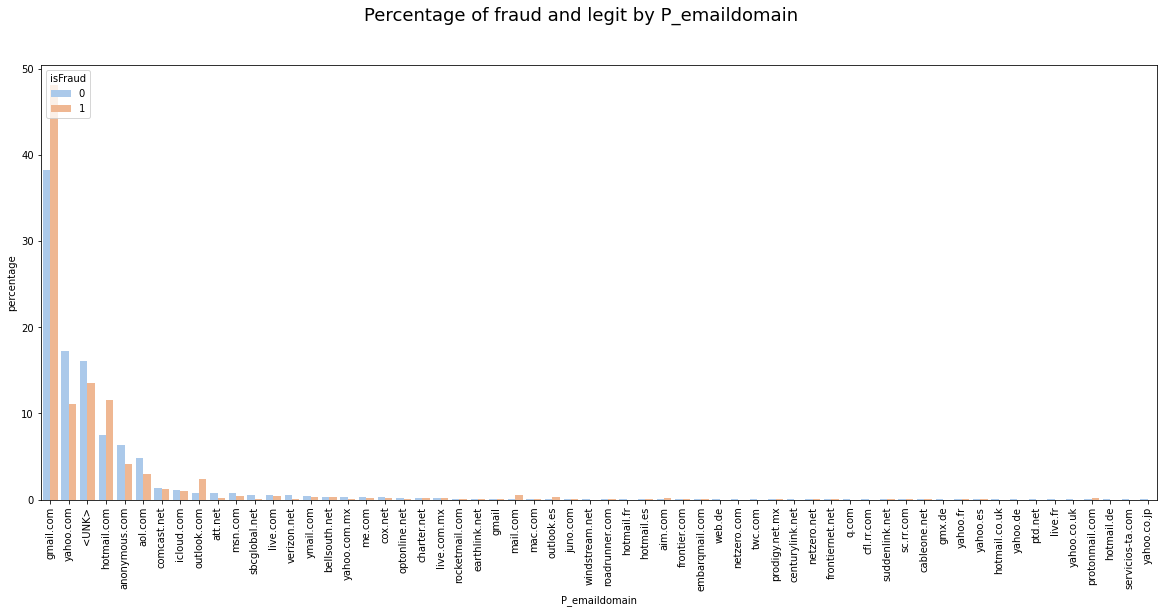

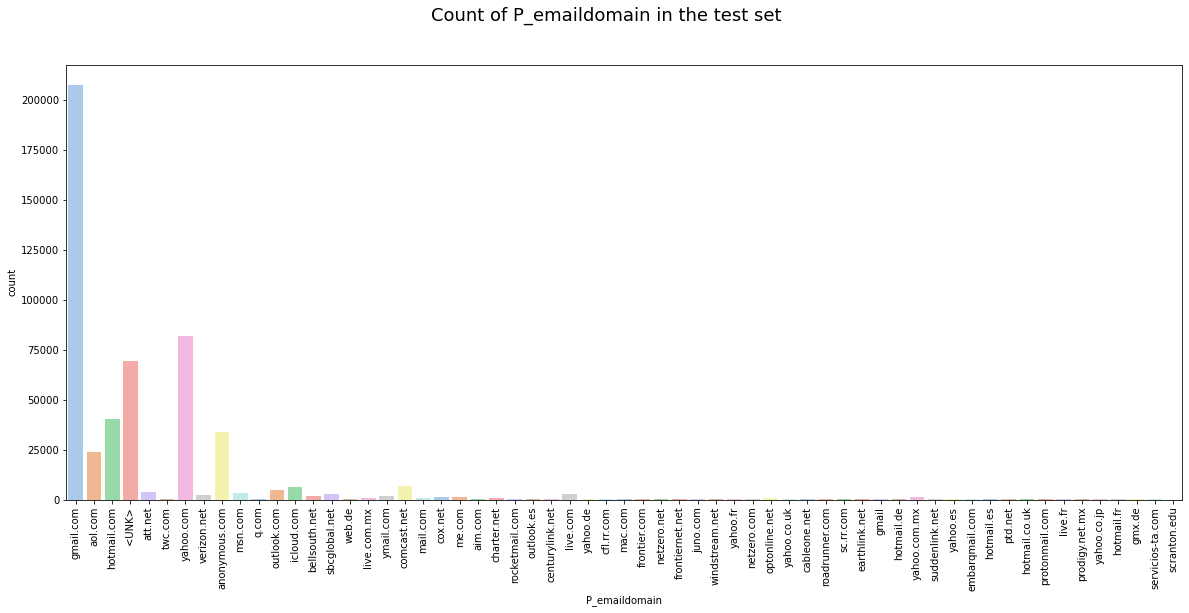

In [85]:
TTCountPlot(df_train,df_test,'P_emaildomain',dep_var)

We can see that some domain names have typos. fixing them could help but I have no time to do that. but it is a good thing to give a try.

# Analysis of DeviceType

In [86]:
describeCategory(df_train, df_test, 'DeviceType')

,DeviceType,Train,TrainFraud,TrainLegit,Test
0,count,140810,11211,129599,136931
1,unique,2,2,2,2
2,top,desktop,mobile,desktop,desktop
3,freq,85165,5657,79611,74403
4,NaN,449730,9452,440278,369760
5,NaNshare,0.761557,0.457436,0.772584,0.729754


In [87]:
df_train.loc[df_train['DeviceType'].isnull(),'DeviceType'] = '<UNK>'
df_test.loc[df_test['DeviceType'].isnull(),'DeviceType'] = '<UNK>'

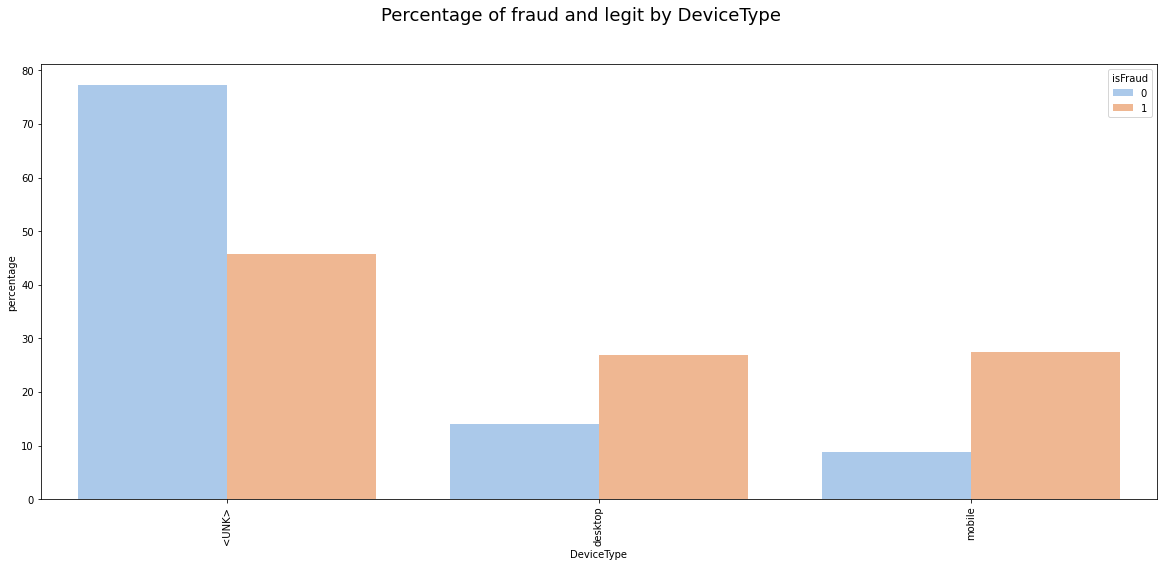

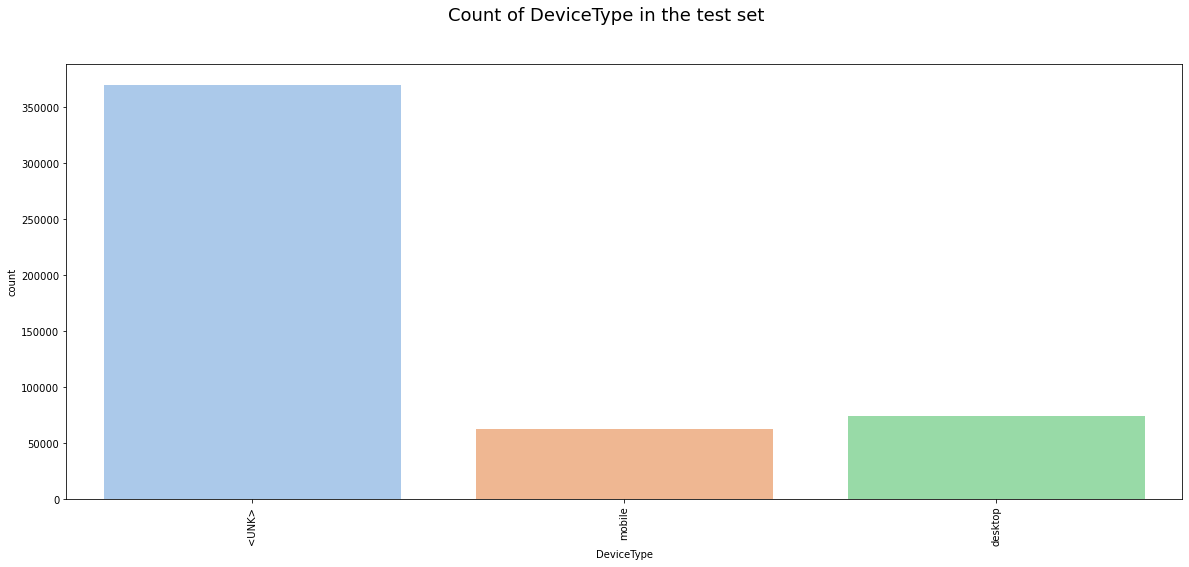

In [88]:
TTCountPlot(df_train,df_test,'DeviceType',dep_var)

# Analysis of DeviceInfo

In [89]:
describeCategory(df_train, df_test, 'DeviceInfo')

,DeviceInfo,Train,TrainFraud,TrainLegit,Test
0,count,118666,8607,110059,115057
1,unique,1786,420,1740,2226
2,top,Windows,Windows,Windows,Windows
3,freq,47722,3121,44601,44988
4,NaN,471874,12056,459818,391634
5,NaNshare,0.799055,0.583458,0.806872,0.772925


In [90]:
df_train.loc[df_train['DeviceInfo'].isnull(),'DeviceInfo'] = '<UNK>'
df_test.loc[df_test['DeviceInfo'].isnull(),'DeviceInfo'] = '<UNK>'

In [95]:
df_train['DeviceInfo'].value_counts()

DeviceInfo    
<UNK>             471874
Windows            47722
iOS Device         19782
MacOS              12573
Trident/7.0         7440
                   ...  
QTASUN1                1
QwestIE8               1
0PJA2                  1
RCT6K03W13             1
xs-Z47b7VqTMxs         1
Length: 1787, dtype: int64

In [97]:
df_train['DeviceInfo'].unique().tolist()

['<UNK>',
 'SAMSUNG SM-G892A Build/NRD90M',
 'iOS Device',
 'Windows',
 'MacOS',
 'SM-G930V Build/NRD90M',
 'BLADE A602 Build/MRA58K',
 'XT1635-02 Build/NPN26.118-22-2',
 'Z970',
 'SM-N920V Build/NRD90M',
 'Redmi Note 4 Build/MMB29M',
 'Lenovo PB1-750M Build/S100',
 'LT22i Build/6.2.A.1.100',
 'rv:52.0',
 'SM-G950U Build/NRD90M',
 'LG-H872 Build/NRD90U',
 'LG-K500 Build/MMB29M',
 'SM-P550 Build/MMB29M',
 'SM-J700M Build/MMB29K',
 'Trident/7.0',
 'rv:57.0',
 'SAMSUNG SM-G930T Build/NRD90M',
 'Blade V6 Plus Build/MRA58K',
 'BLL-L23 Build/HUAWEIBLL-L23',
 'KYOCERA-C6742A Build/LMY47V',
 'F3113 Build/33.2.A.4.70',
 'D5306 Build/19.4.A.0.182',
 'M4 SS4457 Build/MRA58K',
 'SM-G955U Build/NRD90M',
 'SM-G610M Build/MMB29K',
 'SAMSUNG SM-G935F Build/NRD90M',
 'XT1635-01',
 'rv:56.0',
 'VS500',
 'CAM-L03 Build/HUAWEICAM-L03',
 'RCT6303W87M7 Build/MRA58K',
 'M4 SS4451 Build/LMY47D',
 'KFFOWI Build/LVY48F',
 'Moto E (4) Build/NMA26.42-19',
 'SAMSUNG',
 'E2306 Build/26.3.A.1.33',
 'Ilium L910 Build

There are a lot of things we can do with this column. one quick idea could be to separate brand name from model.

# Analysis of addr1

In [100]:
describeCategory(df_train, df_test, 'addr1')

,addr1,Train,TrainFraud,TrainLegit,Test
0,count,524834,12922,511912,441082
1,unique,332,86,332,292
2,top,299.0,204.0,299.0,299.0
3,freq,46335,1120,45350,38710
4,NaN,65706,7741,57965,65609
5,NaNshare,0.111264,0.374631,0.101715,0.129485


In [101]:
df_train.loc[df_train['addr1'].isnull(),'addr1'] = '<UNK>'
df_test.loc[df_test['addr1'].isnull(),'addr1'] = '<UNK>'

In [104]:
df_train['addr1'].value_counts()

<UNK>    65706
299.0    46335
325.0    42751
204.0    42020
264.0    39870
         ...  
368.0        1
463.0        1
163.0        1
153.0        1
101.0        1
Name: addr1, Length: 333, dtype: int64

The address could have information. we could create an embeddings of addresses and see id there is simularity between addresses that are close to each other.